# **Vehicle Detection and Tracking** 
***
The goals / steps of this project are the following:
    
     1. Apply a color transform and append binned color features, as well as histograms of color
    
    2. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier, append HOG vector to color feature vector   
    
    3. Extract Features from training images to train selected classier
    
    4. Implement a sliding-window technique and use trained classifier to search for vehicles in images.
    
    5. Use heatmap technique to eliminate negative positive detection.
    
    6. Use label to find continuous non-zero area in threshold heat map and draw single box for detected vehicles
    
    7. Run the pipeline created from step 4-6 on a video stream  and draw outlined box on vehicle in the video


---

In [1]:
#importing packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import pickle
import glob
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
%matplotlib inline



In [2]:
#Test image folder
test_dir = "test_images/"

#Training image folder 
dataset_dir = "dataset/"

#Output image folder
output_dir = "output_images/"

## Extract Feactures

Convert color space into feature vector which can be used in classifier training. In this project, following 
features are used: 
1) spatial binning of color

2) color histogram  

3) HOG (Historgram of Oriented Gradient).


**Spatial Binning of Color**

Extract feature from raw pixel values of an image. The image from training data is resized into given size like (32, 32) and converted into a vector using openCV ravel().


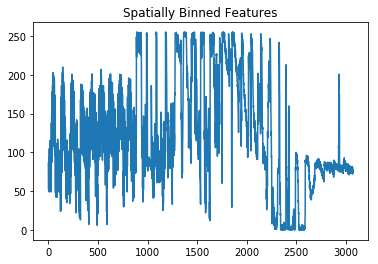

In [3]:
#Function to compute sparial bining of colors
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

    
    
    

test_image =  mpimg.imread(test_dir +'cutout1.jpg')
feature_vec = bin_spatial(test_image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.savefig(output_dir + "spa_bin_feat_ex.png")
plt.show()



**Histograms of Color**

Color is an important feature for vihecle detection,  so color histgram features are etracted

In [4]:
# Function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc. 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features




** Build Data Dictionary **

Load provided dataset for car and noncar images into dictionary


Num of cars:  8792
Num of noncars:  8792
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


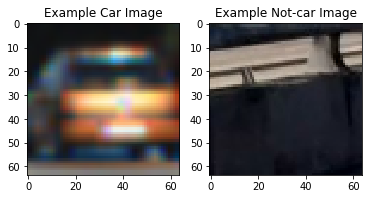

In [5]:

# images are divided up into vehicles and non-vehicles
cars_path_name = dataset_dir + 'vehicles/' + '*/*.png'
notcars_path_name = dataset_dir + 'non-vehicles/' + '*/*.png'


cars = glob.glob(cars_path_name)
notcars = glob.glob(notcars_path_name)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}    
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    print('Num of cars: ', data_dict["n_cars"])
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    print('Num of noncars: ', data_dict["n_cars"])
    # Read in a test image, either car or notcar
    test_image = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.savefig(output_dir + "car_noncar_ex.png")

**HOG(Historgram of Oriented Gradient)**

A car can be distinguished from a non-car by looking at its edges. HOG will compute the gradients from blocks of cells. Then, a histogram is constructed with these gradient values. skimage.feature.hog function is used to extract HOG feature from image

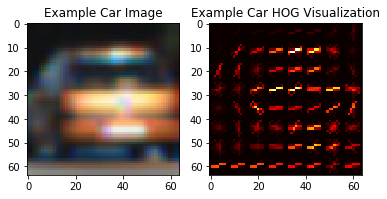

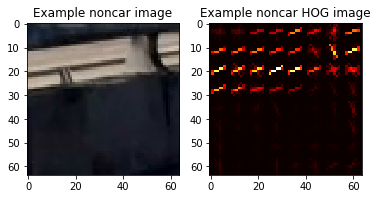

In [6]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image =hog(img,
                             orientations=orient, 
                             pixels_per_cell=(pix_per_cell, pix_per_cell), 
                             cells_per_block=(cell_per_block, cell_per_block), 
                             visualise=vis, 
                             feature_vector=feature_vec)
       
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features =hog(img,
                             orientations=orient, 
                             pixels_per_cell=(pix_per_cell, pix_per_cell), 
                             cells_per_block=(cell_per_block, cell_per_block), 
                             visualise=vis, 
                             feature_vector=feature_vec)
        return features

pix_per_cell = 8
cell_per_block = 2
orient = 9
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
car_features, car_hog_image = get_hog_features(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
notcar_features, notcar_hog_image = get_hog_features(notcar_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(car_hog_image, cmap = 'hot')
plt.title('Example Car HOG Visualization')
plt.savefig(output_dir + "car_hog_ex.png")
plt.show()
fig = plt.figure()
plt.subplot(121)
plt.imshow(notcar_image)
plt.title('Example noncar image')
plt.subplot(122)
plt.imshow(notcar_hog_image, cmap = 'hot')
plt.title('Example noncar HOG image')
plt.savefig(output_dir + "noncar_hog_ex.png")
plt.show()



**Extract features for single image**

Combine all 3 type of features in one vector

In [7]:
# Function to extract all training features from a single image and concate them in a vector
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        # Resacale back between 0 and 1
        feature_image = feature_image.astype(np.float32)/255.0    
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

## Train Classifier

Extract features from training images and train selected classifier.  LinearSVC, SVM, RandomForestClassifier, DecisionTreeClassifier tree and AdaBoostClassifier  provided by sklearn are tested with different color spaces: like RGB, LUV, HSV, HLS, YCrCb. The result can be found in different notebook. For example: RGB with different classifier, see result in P5-Test-Classifier-RGB.ipynb. Finally, it looks like YCrCb space with LinearSVC classifier gave best result. So in this notebook, YCrCb color space and LinearSVC classifier will be used.


**Parameters for feature extraction**

These parameters can be tuned to get different result. Lot of tests have been done to tune those parameter, those parameter chosen here is best result in my tests.

In [8]:
### Parameters for feature extraction 
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

**Build Training and Test dataset**

Extract features for all images in dataset, nomalize the feature vectors and randomly split them into train and test dataset.

In [9]:
# parameters as a dictionary
feature_extract_params = {'color_space': color_space,
                  'orient': orient,
                  'pix_per_cell': pix_per_cell,
                  'cell_per_block': cell_per_block,
                  'hog_channel': hog_channel,
                  'spatial_size': spatial_size,
                  'hist_bins': hist_bins,
                  'spatial_feat': spatial_feat,
                  'hist_feat': hist_feat,
                  'hog_feat': hog_feat}


car_features =[]
notcar_features = []

#Extract features for all car images in dataset
for file in cars:
    # Read in each one by one
    image = mpimg.imread(file)
    img_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
    car_features.append(img_features)

#Extract features for all noncar images in dataset
for file in notcars:
    # Read in each one by one
    image = mpimg.imread(file)
    img_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
    notcar_features.append(img_features)  

#Stack car and noncar feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 

print('Image feature vector length:', len(X[0]))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


#Save train data set in a picle file for calssifier training

DATASET_FILE = "extracted_features/p5_dataset_YCrCb.pkl"

dist_pickle = {}
dist_pickle["X_train"] = X_train 
dist_pickle["y_train"] = y_train
dist_pickle["X_test"] = X_test 
dist_pickle["y_test"] = y_test
dist_pickle["feature_extract_params"] = feature_extract_params 
dist_pickle["X_scaler"] = X_scaler
try:
    pickle.dump( dist_pickle, open( DATASET_FILE, "wb" ) )
except Exception as e:
    print('Unable to save data to', DATASET_FILE, ':', e)
    raise    

print('Extracted feature dataset saved')    



Image feature vector length: 6156
Extracted feature dataset saved


In [10]:
#Reload training, test data labels, scaler, and parameter from saved pickle file

with open(DATASET_FILE, 'rb') as f:
        pickle_data = pickle.load(f)
        X_train = pickle_data['X_train']
        y_train = pickle_data['y_train']
        X_test = pickle_data['X_test']
        y_test = pickle_data['y_test']
        X_scaler = pickle_data['X_scaler']
        feature_extract_params = dist_pickle['feature_extract_params']
        del pickle_data # Free up memor
print('Data and modules loaded.')
print("train_features size:", X_train.shape)
print("train_labels size:", y_train.shape)
print("test_features size:", X_test.shape)
print("test_labels size:", y_test.shape)
for key in feature_extract_params.keys():
    print(key, ":", feature_extract_params[key]) 
    
color_space = feature_extract_params['color_space']
orient = feature_extract_params['orient']
pix_per_cell = feature_extract_params['pix_per_cell']
cell_per_block = feature_extract_params['cell_per_block']
hog_channel = feature_extract_params['hog_channel']
spatial_size = feature_extract_params['spatial_size']
hist_bins = feature_extract_params['hist_bins']
spatial_feat = feature_extract_params['spatial_feat']
hist_feat = feature_extract_params['hist_feat']
hog_feat = feature_extract_params['hog_feat']        

Data and modules loaded.
train_features size: (14208, 6156)
train_labels size: (14208,)
test_features size: (3552, 6156)
test_labels size: (3552,)
color_space : YCrCb
pix_per_cell : 8
hist_bins : 32
spatial_feat : True
cell_per_block : 2
hog_channel : ALL
hog_feat : True
orient : 9
hist_feat : True
spatial_size : (16, 16)


**Train Classifier**

Use training dataset to train classifier and use test set to validate calissifier. LinearSVC classifier is used in this project

In [11]:
# Use a linear SVC 
svc = LinearSVC(max_iter=20000)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

5.76 Seconds to train SVC...
Test Accuracy of SVC =  0.9842


## Sliding Window Technique

Slide Window Example


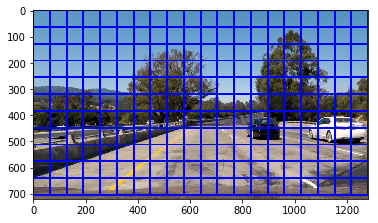

In [12]:
#Utilty function to display image
def showImage(img, title, cmap = None):
    print (title)
    if cmap is None:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=cmap)    
    plt.show()


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

image = mpimg.imread(test_dir + 'test1.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
showImage(window_img, 'Slide Window Example')
mpimg.imsave(output_dir + "sliding_win_ex.png", window_img)

## Search Window and Classify

Divide image into small window using sliding window technique and use trained classifier to detect if there is a vehicle in each window. And multiple window size will be used to search vehicles in the image. Heat map threshold will be used to reduce false positive. And label will be used to find non-zero aread to  to mark the detected vehicle with single box.

**Search vehicle in sliding windows**

In [13]:
# Function to search sliding windows on the image to find windows containing vehicle image 
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        resized_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(resized_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Test image shape:  (720, 1280, 3)
Car Detection Example


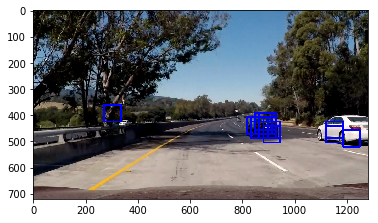

In [14]:
test_image = mpimg.imread(test_dir + 'test5.jpg')
draw_test_image = np.copy(test_image)
print('Test image shape: ', test_image.shape)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
test_image = test_image.astype(np.float32)/255
y_offset = 40
y_start = test_image.shape[0]//2
y_stop = test_image.shape[0] - y_offset
xy_window = (64, 64)
y_start_stop=[y_start, y_stop]
xy_overlap = (0.75, 0.75)


windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap = xy_overlap
                      )

hot_windows = search_windows(test_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

test_window_img = draw_boxes(draw_test_image, hot_windows, color=(0, 0, 255), thick=6)                    

mpimg.imsave(output_dir + "car_sin_win_ex.png", test_window_img)
showImage(test_window_img, 'Car Detection Example')




**Dectect Vehicle using different sliding window size**

Different windows sized were tested. And finally window size of (64, 64), (96, 96),  (128, 128) were used in this project.

Window Size: (64, 64)


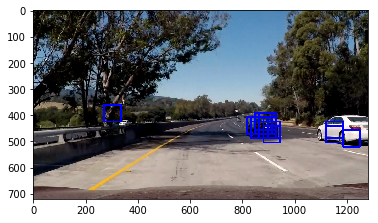

Window Size: (96, 96)


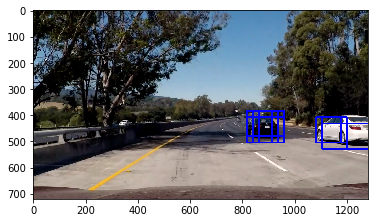

Window Size: (128, 128)


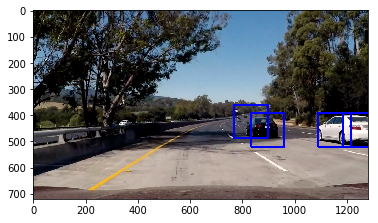

Combined hot windows


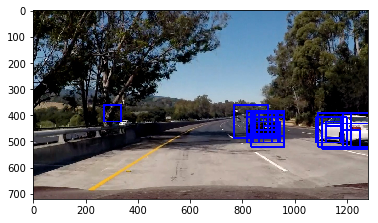

In [15]:

#xy_windows = [(64, 64), (84, 84), (96, 96), (112, 112), (128, 128), (144, 144)]
xy_windows = [(64, 64), (96, 96),  (128, 128)]


test_image = mpimg.imread(test_dir + 'test5.jpg')

draw_test_image = np.copy(test_image)
test_image = test_image.astype(np.float32)/255

test_all_hot_windows = []



for xy_wd in xy_windows:
   
    test_iamge_2 = np.copy(test_image)
    draw_test_image_2 = np.copy(draw_test_image)
    windows = slide_window(test_iamge_2, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_wd, xy_overlap = xy_overlap
                      )
    hot_windows = search_windows(test_iamge_2, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    test_all_hot_windows.extend(hot_windows)
    window_img = draw_boxes(draw_test_image_2, hot_windows, color=(0, 0, 255), thick=6)
    showImage(window_img, 'Window Size: ' + str(xy_wd))
   


test_combined_window_img =  draw_boxes(draw_test_image, test_all_hot_windows, color=(0, 0, 255), thick=6)  
mpimg.imsave(output_dir + "car_mul_win_ex.png", test_combined_window_img)
showImage(test_combined_window_img, 'Combined hot windows')



Now for the one with the solid yellow lane on the left. This one's more tricky!

**Reduce false positive using heat map **

Heat map is used to reduce fals positive. Assuption here is that the false postive object will has much less hot windows than the real vehicle objects. So if a proper threshold is applied to head map, false positive object should be filtered out.

In [16]:
#Function add heat to blank heat map
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
#Function to apply threshold to eliminate false positive    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


Heatmap Example


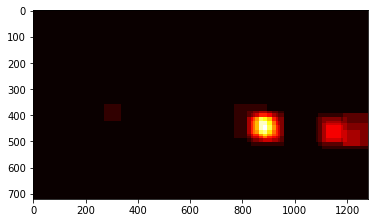

Threshold Heatmap Example


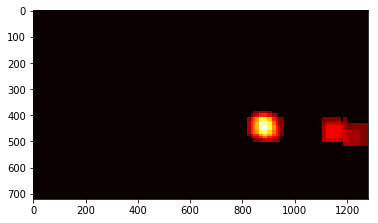

In [17]:
test_heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
test_heatmap = add_heat(test_heat, test_all_hot_windows)
mpimg.imsave(output_dir + "heatmap_ex.png", test_heatmap, cmap='hot')
showImage(test_heatmap, 'Heatmap Example', cmap='hot')
test_th_heatmap = apply_threshold(test_heatmap, 2)
mpimg.imsave(output_dir + "heatmap_thr_ex.png", test_th_heatmap, cmap='hot')
showImage(test_th_heatmap, 'Threshold Heatmap Example', cmap='hot')


**Label and draw single box marking detected vehicle **

label from scipy.ndimage.measurements is used to find contineous nonzero areas and label them starting from 1 and set the background as 0. And min and max point will be picked will be used to draw single box around detect vehicle.

2 cars found
Label


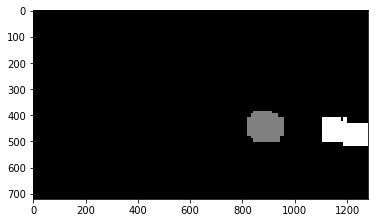

Vehicle Marked


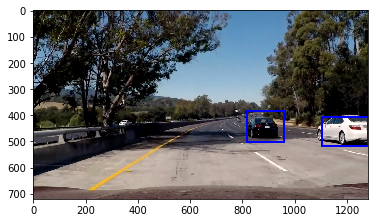

In [18]:
from scipy.ndimage.measurements import label

test_image = mpimg.imread(test_dir + 'test5.jpg')
draw_test_image = np.copy(test_image)
test_labels = label(test_th_heatmap)
print(test_labels[1], 'cars found')
mpimg.imsave(output_dir + "label_heatmap_ex.png", test_labels[0], cmap='gray')
showImage(test_labels[0], 'Label', cmap='gray')


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Draw bounding boxes on a copy of the image
test_result_img = draw_labeled_bboxes(draw_test_image, test_labels)
mpimg.imsave(output_dir + "result_ex.png", test_result_img)
# Display the image
showImage(test_result_img, 'Vehicle Marked')  
    


**Pipeline Implementation **

Put previouse steps togather and create pipeline to detect vicheil in image

file name: test5.jpg
Processed Image


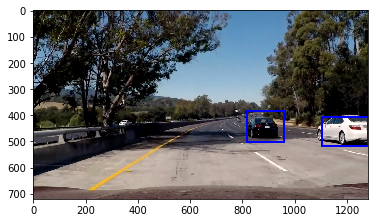

file name: test6.jpg
Processed Image


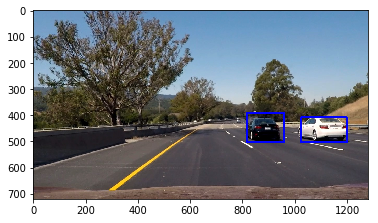

file name: test4.jpg
Processed Image


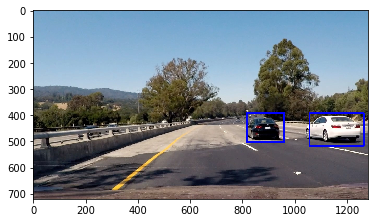

file name: test1.jpg
Processed Image


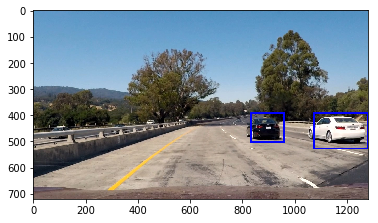

file name: test3.jpg
Processed Image


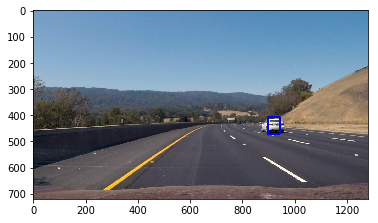

file name: test2.jpg
Processed Image


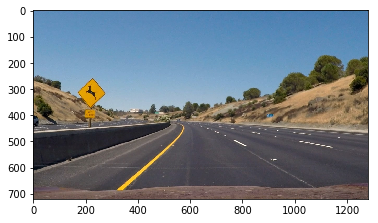

In [20]:
#Heatmap threshold
heat_threshold = 2

#Function to process image frame from video
def pipeline(image, clf, X_scaler, 
                    x_start_stop=[None, None], 
                    y_start_stop=[None, None], 
                    xy_windows=[(96, 96)], 
                    xy_overlap=(0.5, 0.5),  
                    color_space=("RGB"), 
                    spatial_size=32,
                    hist_bins=32, 
                    orient=9,
                    pix_per_cell=8, 
                    cell_per_block=2, 
                    hog_channel=0,
                    spatial_feat=True, 
                    hist_feat=True,
                    hog_feat=True,
                    scale = True ):
    
    pl_all_hot_windows = []    
    draw_image = np.copy(image)
    if scale:
        image = image.astype(np.float32)/255 #Scale to (0, 1)   
    for xy_wd in xy_windows:
        image_copy = np.copy(image)    
        pl_windows = slide_window(image_copy, 
                               x_start_stop=x_start_stop, 
                               y_start_stop=y_start_stop, 
                               xy_window=xy_wd,
                               xy_overlap = xy_overlap
                  )
        pl_hot_windows = search_windows(image_copy, pl_windows, 
                                     svc, X_scaler,
                                     color_space=color_space, 
                                     spatial_size=spatial_size,
                                     hist_bins=hist_bins, 
                                     orient=orient,
                                     pix_per_cell=pix_per_cell, 
                                     cell_per_block=cell_per_block, 
                                     hog_channel=hog_channel,
                                     spatial_feat=spatial_feat, 
                                     hist_feat=hist_feat,
                                     hog_feat=hog_feat) 
        pl_all_hot_windows.extend(pl_hot_windows)
        
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, pl_all_hot_windows)
    th_heatmap = apply_threshold(heatmap, heat_threshold)
    labels = label(th_heatmap)
    result_img = draw_labeled_bboxes(draw_image, labels)
    return result_img

import os

test_folder = "test_images"
test_images = os.listdir(test_folder)
i = 1
for img_ele in test_images:
     
    if  not('test' in img_ele):
        continue  
    print('file name:',  img_ele)
    test_image_file = os.path.join(test_folder, img_ele)    
    test_image = mpimg.imread(test_image_file)   
    test_result_image = pipeline(test_image, svc, X_scaler,
                    x_start_stop=[None, None], 
                    y_start_stop=y_start_stop, 
                    xy_windows=xy_windows, 
                    xy_overlap=xy_overlap,  
                    color_space=color_space, 
                    spatial_size=spatial_size,
                    hist_bins=hist_bins, 
                    orient=orient,
                    pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel,
                    spatial_feat=spatial_feat, 
                    hist_feat=hist_feat,
                    hog_feat=hog_feat,
                    scale = True             
                    )
    # Plot the examples
    #showImage(test_image, 'Original Image')
    mpimg.imsave(output_dir + "result_ex_" + str(i) + ".png", test_result_img)
    i+=1
    showImage(test_result_image, 'Processed Image')
   


**Process project video with pipeline **

Process project video frame by frame with pipeline.

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def process_image(frame_image):
       
    v_result_image = pipeline(frame_image, svc, X_scaler,
                    x_start_stop=[180, None], 
                    y_start_stop=y_start_stop, 
                    xy_windows=xy_windows, 
                    xy_overlap=xy_overlap,  
                    color_space=color_space, 
                    spatial_size=spatial_size,
                    hist_bins=hist_bins, 
                    orient=orient,
                    pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel,
                    spatial_feat=spatial_feat, 
                    hist_feat=hist_feat,
                    hog_feat=hog_feat,
                    scale = True           
            )

    return v_result_image

In [23]:
output = 'P5_solution_v6.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video P5_solution_v6.mp4
[MoviePy] Writing video P5_solution_v6.mp4


100%|█████████▉| 1260/1261 [2:07:23<00:05,  5.94s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P5_solution_v6.mp4 

CPU times: user 8h 27min 39s, sys: 1min 50s, total: 8h 29min 29s
Wall time: 2h 7min 24s


In [24]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))

**Final Result **

The project restul video can also be viewed from following link:
https://youtu.be/VpdrtnY0if0

## Reflections

Here are some challenges and thoughts that I had in this project:

    1. Feature extraction to classify vehicle and non-vehicle. In this project, color histogram, spatial binning of colors, and histogram of oriented gradient(HOG) features were extracted and used as features to detect vehicle. There are so many image feature can be used for this purpose, so find proper features is a very challenge work. In this project, those thee types of feature used is effective but it may not be robust enough for other situation.

    2. Classifier search and training. I tried several classifier from sklearn. It looks like the linear SVM classifier introduced in course material perform best. I could get high accuracy in Rainforest classifier but it doesn't perform well in real detection in test image. I am not sure why. As another thought, convolution neural network may be used to classify vehicle which may provide better result. And it can be next step to carry this project further.

    3. False positive reducing. The accuracy of classifier is not nigh enough, only 0.9845. I would like to improve it to over 0.99. The provided training dataset is not well balanced. I found generally, it detected dark color car better than light color car in all classifier that I tested. So the classifier tends to detect shaded tree or dark area on separation block as vehicle. Playing with different sliding window size, and heat map threshold may be able to eliminate them but making the training data more balanced and generalizing classifier may be a better approach
    
    4. HOG feature extraction is computation intensive operation. Calculating HOG for whole image once and extract feature for sliding windows from the calculated feature array will be much more effetive way to extract HOG feature. That is another improvement that can be done. 

